### Spectrograms Extraction
Automation script for extracting spectrograms (as .npy files) from .wav snippets and creating metadata csv file.

In [1]:
import librosa
import scipy
import librosa.display
import numpy as np
import os
import csv

def high_pass_filter(data, sr, cutoff, order=4):
    """
    Apply high-pass filter to audio data.
    Args:
        data: (np.array) Audio data
        sr: (int) Sample rate
        cutoff: (int) Cutoff frequency in Hz
        order: (int) Order of the filter
    """
    nyquist = 0.5 * sr  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    # Design filter
    b, a = scipy.signal.butter(order, normal_cutoff, btype="high", analog=False)
    # Apply filter
    filtered_data = scipy.signal.filtfilt(b, a, data)
    return filtered_data

def audio_to_spectrogram(file_path, cutoff_frequency=40, resampling_rate = 7920, fft_size=511, hop_length=31):
    """
    Compute the spectrogram of an audio file.
    Args:
        file_path: (str) Path to the audio file
        cutoff_frequency: (int) Cutoff frequency for high-pass filter
        resampling_rate: (int) Resampling rate
        fft_size: (int) FFT size
        hop_length: (int) Hop length
    """
    audio_data, sample_rate = librosa.load(file_path, sr=resampling_rate) #loading and resampling

    # Apply a highpass filter with a cutoff frequency of 40Hz
    audio_data = high_pass_filter(audio_data, sample_rate, cutoff=cutoff_frequency)

    # Compute Short-Time Fourier Transform (STFT)
    S = librosa.stft(audio_data, n_fft=fft_size, hop_length=hop_length ,window='hann')
    S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    
    return S_dB

Extract spectrograms for all created wav snippets and create metadata file for later CNN training.

In [2]:
# define input (sound snippets as .wav) and output (spectrograms as .npy) directories
base_path_database = '/Users/jannisdaiber/Documents/Repos/github/ProjectMedicalWearables/Database'
base_path_wav = os.path.join(base_path_database, 'snippet_wavs')
base_path_spectrograms = os.path.join(base_path_database, 'spectrograms')

# prepare for creation of metadata file 
metadata = []
food_type = None
label_class = None

# counters for filenames of extracted spectrograms
chewing_count = 0
swallowing_count = 0
others_count = 0
resting_count = 0


# traverse input directory, extract spectrogram for every .wav file and append metadata 
for root, directories, files in os.walk(base_path_wav):
    for dir in directories:
        if 'participant' in dir:
            for participant_root, _, wav_snippets in os.walk(os.path.join(base_path_wav, dir)):
                for snippet in wav_snippets:
                    if snippet.endswith('.wav'):
                        label_class = snippet.split('_')[0].lower()
                        augmented_flag = 'aug' in snippet
                        spectrogram = audio_to_spectrogram(os.path.join(participant_root, snippet))
                
                        if label_class == 'chewing':
                            chewing_count += 1
                            spectrogram_path = os.path.join(base_path_spectrograms, dir, label_class + str(chewing_count) + '.npy')
                            food_type = snippet.split('_')[1].lower()
                            np.save(spectrogram_path, spectrogram)
                        elif label_class == 'swallowing':
                            swallowing_count += 1
                            spectrogram_path = os.path.join(base_path_spectrograms, dir, label_class + str(swallowing_count) + '.npy')
                            food_type = snippet.split('_')[1].lower()
                            np.save(spectrogram_path, spectrogram)
                        elif label_class == 'others':
                            others_count += 1
                            spectrogram_path = os.path.join(base_path_spectrograms, dir, label_class + str(others_count)  + '.npy')
                            food_type = "none"
                            np.save(spectrogram_path, spectrogram)
                        elif label_class == 'resting':
                            resting_count += 1
                            spectrogram_path = os.path.join(base_path_spectrograms, dir, label_class + str(resting_count) + '.npy')
                            food_type = "none"
                            np.save(spectrogram_path, spectrogram)

                        metadata.append({'participant': dir, 'label': label_class, 'spectrogram_path': spectrogram_path, 'food_type': food_type, 'augmented_flag': augmented_flag, 'wav_path': os.path.join(participant_root, snippet)})

# save metadata as .csv
with open(os.path.join(base_path_database, 'metadata.csv'), 'w', newline='') as csvfile:
    fieldnames = ["participant", "label", "spectrogram_path", "food_type", "augmented_flag", "wav_path"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(metadata)                    

Example plot of two spectrograms.

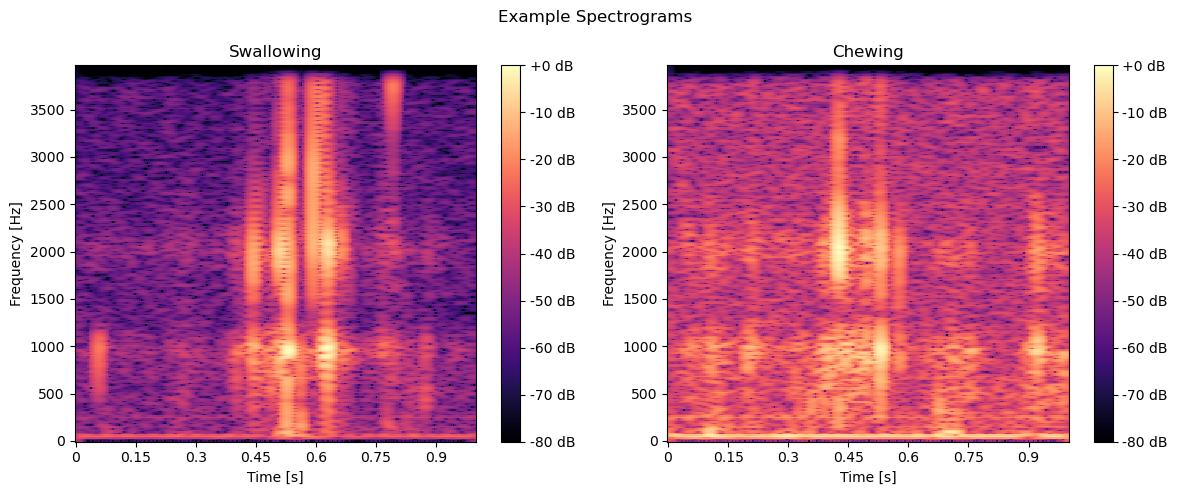

In [37]:
import matplotlib.pyplot as plt

audio_file1 = '/Users/jannisdaiber/Documents/Repos/github/ProjectMedicalWearables/Database/snippet_wavs/participant01/session01/swallowing_apple_103.349_104.349.wav'
audio_file2 = '/Users/jannisdaiber/Documents/Repos/github/ProjectMedicalWearables/Database/snippet_wavs/participant01/session01/chewing_apple_100.572_101.572.wav'
S1_dB = audio_to_spectrogram(audio_file1)
S2_dB = audio_to_spectrogram(audio_file2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

img1 = librosa.display.specshow(S1_dB, hop_length = 31, sr=7920, x_axis='time', y_axis='linear', ax=axes[0])
axes[0].set_title('Swallowing')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Frequency [Hz]')
fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')

img2 = librosa.display.specshow(S2_dB, hop_length = 31, sr=7920, x_axis='time', y_axis='hz', ax=axes[1])
axes[1].set_title('Chewing')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Frequency [Hz]')
fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')

fig.suptitle('Example Spectrograms')

plt.tight_layout()
plt.show()